# THCS
- applied to practical scenarios

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import time
import os
import numpy as np
import pandas as pd
from collections import OrderedDict
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.stats as st

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy

import sys
sys.path.append("..")
from redo_handy_utils import *
from redo_utils import *
from dl_utils import *

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [ ]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:1')
else:
    device = torch.device('cpu')

# tensorboard path
basepath = '/home/wengqy20/ML - work'
model_path = '06 - PINN/07 - code github/05 - practical scenarios'
log_path = '06 - PINN/07 - code github/05 - practical scenarios/tensorboard'
date_suf = 'THCS - ' + datetime.now().strftime("%Y%m%d - %H%M%S")
writer = SummaryWriter(os.path.join(basepath, log_path,  date_suf))

## Network framework

In [ ]:
# DNN
class DNN(torch.nn.Module):
    def __init__(self, layers):
        '''
        Args:
        layers  ::  array-like, number of neurons in each layer of the neural network
        
        '''
        super(DNN, self).__init__()
        # Network depth
        self.depth = len(layers) - 1
        
        # activation function
        # self.activation = torch.nn.ReLU
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        # hidden layer
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
        # output layer
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        self.layers = torch.nn.Sequential(layerDict).to(device)
        
    def forward(self, x):
        out = self.layers(x)
        return out

def initialize_net(net):
    net_name = net.__class__.__name__                               # 2
    if net_name.find('layer') != -1:                                              
        nn.init.xavier_normal_(net.weight)
        nn.init.xavier_normal_(net.bias)

In [ ]:
# THCS
class THCS():
    def __init__(self, X_eq, U_eq, X_gap, U_gap, X_nw, T_nw, model_s, model_u, model_v, model_T, prop_net, **kargs):
        '''
        Args:
        X_eq     ::  2d array, coordinate of scarce samples used for label loss
        U_eq     ::  2d array, physical parameters of scarce samples used for label loss
        X_gap    ::  2d array, coordinate of scarce samples used for equation loss
        U_gap    ::  2d array, physical parameters of scarce samples used for equation loss
        X_nw     ::  2d array, coordinate of scarce samples used for wall-temperature loss
        T_nw     ::  2d array, temperature of scarce samples used for wall-temperature loss
        model    ::  pkl, THCS model
        prop_net ::  pkl, MLP for thermal property mapping
        
        '''
        
        self.X_eq = torch.tensor(X_eq, requires_grad=True).float().to(device)
        self.U_eq = torch.tensor(U_eq, requires_grad=True).float().to(device)
        self.X_gap = torch.tensor(X_gap, requires_grad=True).float().to(device)
        self.U_gap = torch.tensor(U_gap, requires_grad=True).float().to(device)
        self.X_nw = torch.tensor(X_nw, requires_grad=True).float().to(device)
        self.T_nw = torch.tensor(T_nw, requires_grad=True).float().to(device)
        self.dnn_s = model_s
        self.dnn_u = model_u
        self.dnn_v = model_v
        self.dnn_T = model_T
        self.prop_net = prop_net
        self.lb_T = kargs['T_lb']  # lower bound for the input of property network
        self.ub_T = kargs['T_ub']  # upper bound for the input of property network
        self.prop_cof = kargs['prop_cof']  # coefficient for property network
        self.T_pc = kargs['Tpc']  # pseudo-critical temperature
        self.ub = torch.tensor(kargs['ub'], requires_grad=True).float().to(device)  # lower bound for the input of main network
        self.lb = torch.tensor(kargs['lb'], requires_grad=True).float().to(device)  # upper bound for the input of main network
        self.loss_weight = kargs['loss_weight']  # weights of loss function

        self.u_eq = self.U_eq[:, 0:1]
        self.v_eq = self.U_eq[:, 1:2]
        self.T_eq = self.U_eq[:, 2:3]
        self.p_eq = self.U_eq[:, 7:8]
        self.data_0d = kargs['data_0d']
        self.fluid = 'CO2'

        # Dimensionless number
        self.T0 = self.data_0d.loc[0, 'T0']
        self.L0 = self.data_0d.loc[0, 'L0']
        self.U0 = self.data_0d.loc[0, 'U0']
        self.D0 = self.data_0d.loc[0, 'D0']
        self.M0 = self.data_0d.loc[0, 'M0']
        self.k0 = self.data_0d.loc[0, 'k0']
        self.Cp0 = self.data_0d.loc[0, 'Cp0']
        self.hpc = self.data_0d.loc[0, 'hpc'] /self.Cp0/self.T0
        self.prop_scl = [self.prop_cof[0]/self.D0, self.prop_cof[1]/self.M0, self.prop_cof[2]/self.k0, self.prop_cof[3]/self.Cp0/self.T0]  # scale factor for property network

        self.gx = -9.8  # upward flow
        self.Fr = self.U0**2 / (self.gx * self.L0)
        self.Re = self.D0 * self.U0 * self.L0 / self.M0
        self.Pr = self.M0 * self.Cp0 * self.k0
       
        self.iter = 0

    # physical field prediction by main network
    def net_pd(self, x, r, q):
        """
        Args:
        x   ::  array-like or float, dimensionless x-coordinate
        r   ::  array-like or float, dimensionless r-coordinate

        Return:
        u   ::  array-like or float, dimensionless streamwise velocity
        v   ::  array-like or float, dimensionless radial velocity
        p   ::  array-like or float, dimensionless hydraulic pressure
        T   ::  array-like or float, dimensionless Temperature

        """
        x_scl = 2.0*(x - self.lb[0])/(self.ub[0] - self.lb[0]) - 1.0
        r_scl = 2.0*(r - self.lb[1])/(self.ub[1] - self.lb[1]) - 1.0
        q_scl = 2.0*(q - self.lb[2])/(self.ub[2] - self.lb[2]) - 1.0
        X_scl = torch.concat((x_scl, r_scl, q_scl), dim=1)
        field_s = self.dnn_s(X_scl)
        field_u = self.dnn_u(field_s[:, :24])
        field_v = self.dnn_v(field_s[:, 24:48])
        field_T = self.dnn_T(field_s[:, 48:])
        u_d, p = field_u[:, 0:1], field_u[:, 1:2]
        v_d, Mt = field_v[:, 0:1], field_v[:, 1:2]
        T, kt = field_T[:, 0:1], field_T[:, 1:2]
        u = (1-r)*u_d
        v = (1-r)*v_d
        return u, v, p, T, Mt, kt
    
    # thermal property prediction by property network
    def prop_pd(self, T):
        """
        Args:
        T   ::  array-like or float, dimensionless temperature

        Return:
        D   ::  array-like or float, dimensionless density
        M   ::  array-like or float, dimensionless viscosity
        k   ::  array-like or float, dimensionless conductivity
        h   ::  array-like or float, dimensionless enthalpy

        """
        T_dim = self.T0 * T  # Dimensionalization
        T_scl = 2.0*(T_dim - self.lb_T)/(self.ub_T - self.lb_T) - 1.0
        prop_dim = self.prop_net(T_scl)
        D, M, k, h = self.prop_scl[0]*prop_dim[:, 0:1], self.prop_scl[1]*prop_dim[:, 1:2], self.prop_scl[2]*prop_dim[:, 2:3], self.prop_scl[3]*prop_dim[:, 3:4] - self.hpc
        
        return D, M, k, h
    
    # heat flux prediction
    def qw_pd(self, T, r):
        """
        Args:
        T   ::  array-like or float, dimensionless temperature
        r   ::  array-like or float, dimensionless r-coordinate

        Return:
        qw  ::  array-like or float, dimensionless heat flux

        """
        D, M, k, h = self.prop_pd(T)
        T_y = torch.autograd.grad(
            T, r, 
            grad_outputs=torch.ones_like(T),
            retain_graph=True,
            create_graph=True
            )[0]
        qw = k*T_y
        
        return qw

    # equation loss prediction
    def net_eq(self, x, r, q):
        """ 

        Thermal properties involved in equation losses are mean values in the whole domain.

        """

        u, v, p, T, Mt, kt = self.net_pd(x, r, q)
        D, M, k, h = self.prop_pd(T)

        Du_x = torch.autograd.grad(
            D*u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
            )[0]
        Dv_r = torch.autograd.grad(
            D*v, r, 
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
            )[0]


        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
            )[0]
        u_r = torch.autograd.grad(
            u, r, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
            )[0]

        v_x = torch.autograd.grad(
            v, x, 
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
            )[0] 
        v_r = torch.autograd.grad(
            v, r, 
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
            )[0]

        p_x = torch.autograd.grad(
            p, x, 
            grad_outputs=torch.ones_like(p),
            retain_graph=True,
            create_graph=True
            )[0]
        p_r = torch.autograd.grad(
            p, r, 
            grad_outputs=torch.ones_like(p),
            retain_graph=True,
            create_graph=True
            )[0]


        divU = u_x + (v_r + v/r)  # divergence
        # shear stress 
        shear_xx = 2*(M+Mt) * (u_x - divU/3)
        shear_xr = (M+Mt) * (v_x + u_r)
        shear_rr = 2*(M+Mt) * (v_r - divU/3)
        shear_xx_x = torch.autograd.grad(
            shear_xx, x, 
            grad_outputs=torch.ones_like(shear_xx),
            retain_graph=True,
            create_graph=True
            )[0] 
        shear_xr_r = torch.autograd.grad(
            r*shear_xr, r, 
            grad_outputs=torch.ones_like(shear_xr),
            retain_graph=True,
            create_graph=True
            )[0]
        shear_rx_x = torch.autograd.grad(
            shear_xr, x, 
            grad_outputs=torch.ones_like(shear_xr),
            retain_graph=True,
            create_graph=True
            )[0]
        shear_rr_r = torch.autograd.grad(
            r*shear_rr, r, 
            grad_outputs=torch.ones_like(shear_rr),
            retain_graph=True,
            create_graph=True
            )[0]

        T_x = torch.autograd.grad(
            T, x, 
            grad_outputs=torch.ones_like(T),
            retain_graph=True,
            create_graph=True
            )[0]
        T_r = torch.autograd.grad(
            T, r, 
            grad_outputs=torch.ones_like(T),
            retain_graph=True,
            create_graph=True
            )[0]
        h_x = torch.autograd.grad(
            h, x, 
            grad_outputs=torch.ones_like(h),
            retain_graph=True,
            create_graph=True
            )[0]
        h_r = torch.autograd.grad(
            h, r, 
            grad_outputs=torch.ones_like(h),
            retain_graph=True,
            create_graph=True
            )[0]
        # heat flux
        q_x = (k+kt) * T_x
        q_r = (k+kt) * T_r
        q_xx = torch.autograd.grad(
            q_x, x, 
            grad_outputs=torch.ones_like(q_x),
            retain_graph=True,
            create_graph=True
            )[0]
        q_rr = torch.autograd.grad(
            r*q_r, r, 
            grad_outputs=torch.ones_like(q_r),
            retain_graph=True,
            create_graph=True
            )[0]

        eq_m = Du_x + (Dv_r + D*v/r)  # mass conservation
        eq_u = D*u*u_x + D*v*u_r + p_x - 1/self.Re * (shear_xx_x + shear_xr_r/r) - D/self.Fr  # momentum conservation at direction of x
        eq_v = D*u*v_x + D*v*v_r + p_r - 1/self.Re * (shear_rx_x + shear_rr_r/r - 2*M/r*(v/r - divU/3))  # momentum conservation at direction of r
        eq_T = D*u*h_x + D*v*h_r - 1/self.Re/self.Pr * (q_xx + q_rr/r)  # energy conservation
        return eq_m, eq_u, eq_v, eq_T

    def loss_cal(self):
        eq_m, eq_u, eq_v, eq_T = self.net_eq(self.X_gap[:, 0:1], self.X_gap[:, 1:2], self.X_gap[:, 2:3])  # equation loss
        r_qt = self.X_eq[:, 1:2]
        u_pred, v_pred, p_pred, T_pred, Mt_pred, kt_pred = self.net_pd(self.X_eq[:, 0:1], r_qt, self.X_eq[:, 2:3])  # label loss
        u_pred_nw, v_pred_nw, p_pred_nw, T_pred_nw, Mt_pred_nw, kt_pred_nw = self.net_pd(self.X_nw[:, 0:1], self.X_nw[:, 1:2], self.X_nw[:, 2:3])  # loss of wall temperature, not adopted here

        # loss weight
        l_eq_m, l_eq_u, l_eq_v, l_eq_T = self.loss_weight['loss_eq_m'], self.loss_weight['loss_eq_u'], self.loss_weight['loss_eq_v'], self.loss_weight['loss_eq_T']
        l_u_eq, l_v_eq, l_T_eq, l_p_eq = self.loss_weight['loss_u_eq'], self.loss_weight['loss_v_eq'], self.loss_weight['loss_T_eq'], self.loss_weight['loss_p_eq']
        l_T_nw = self.loss_weight['loss_T_nw']

        loss_eq_m = l_eq_m * torch.mean(eq_m**2)
        loss_eq_u = l_eq_u * torch.mean(eq_u**2)
        loss_eq_v = l_eq_v * torch.mean(eq_v**2)
        loss_eq_T = l_eq_T * torch.mean(eq_T**2)

        # when close to the Tpc, increase the weight
        # idx_Tpc = (abs(self.T_eq - self.T_pc) < 0.03)
        idx_Tpc = (self.X_eq[:, 0] < 20) | (self.X_eq[:, 0] > 160)
        weight_pc = 1
        loss_u_eq = l_u_eq * (torch.mean(((u_pred - self.u_eq)[~idx_Tpc]**2)) + weight_pc*torch.mean(((u_pred - self.u_eq)[idx_Tpc]**2)))
        loss_v_eq = l_v_eq * (torch.mean((1e3*(v_pred - self.v_eq)[~idx_Tpc]**2)) + weight_pc*torch.mean((1e3*(v_pred - self.v_eq)[idx_Tpc]**2)))
        loss_T_eq = l_T_eq * (torch.mean(((T_pred - self.T_eq)[~idx_Tpc]**2)) + weight_pc*torch.mean(((T_pred - self.T_eq)[idx_Tpc]**2)))
        loss_p_eq = l_p_eq * (torch.mean((1e-2*(p_pred - self.p_eq)[~idx_Tpc]**2)) + weight_pc*torch.mean((1e-2*(p_pred - self.p_eq)[idx_Tpc]**2)))
        loss_T_nw = l_T_nw * torch.mean((T_pred_nw - self.T_nw)**2)
        
        loss_u = loss_u_eq + loss_p_eq
        loss_v = loss_v_eq
        loss_T = loss_T_eq +  loss_T_nw
        loss_eq = loss_eq_m + loss_eq_u + loss_eq_v + loss_eq_T 
        loss = loss_u + loss_T + loss_eq + loss_v

        # record loss in tensorboard
        writer.add_scalar('Loss_eq_m', loss_eq_m, self.iter)
        writer.add_scalar('Loss_eq_u', loss_eq_u, self.iter)
        writer.add_scalar('Loss_eq_v', loss_eq_v, self.iter)
        writer.add_scalar('Loss_eq_T', loss_eq_T, self.iter)
        writer.add_scalar('Loss_T_eq', loss_T_eq, self.iter)
        writer.add_scalar('Loss_u_eq', loss_u_eq, self.iter)
        writer.add_scalar('Loss_v_eq', loss_v_eq, self.iter)
        writer.add_scalar('Loss_p_eq', loss_p_eq, self.iter)
        writer.add_scalar('Loss_T_nw', loss_T_nw, self.iter)
        writer.add_scalar('Loss_u', loss_u, self.iter)
        writer.add_scalar('Loss_v', loss_v, self.iter)
        writer.add_scalar('Loss_T', loss_T, self.iter)
        writer.add_scalar('Loss_eq', loss_eq, self.iter)
        writer.add_scalar('Loss', loss, self.iter)
        # print loss
        self.iter += 1
        if self.iter % 50 == 0:
            print('Iteration %d: loss: %.2e' %(self.iter, loss))
            print('loss_eq_m: %.2e, loss_eq_u: %.2e, loss_eq_v: %.2e, loss_eq_T: %.2e' %(loss_eq_m, loss_eq_u, loss_eq_v, loss_eq_T))
            print('loss_u_eq: %.2e, loss_v_eq: %.2e, loss_T_eq: %.2e, loss_p_eq: %.2e, loss_T_nw: %.2e' %(loss_u_eq, loss_v_eq, loss_T_eq, loss_p_eq, loss_T_nw))

        return loss, loss_u, loss_v, loss_T, loss_eq

    # model training
    def train(self, iterat, optimizer_Adam_s, optimizer_Adam_u, optimizer_Adam_v, optimizer_Adam_T, min_lr, patience):
        self.optimizer_Adam_s = optimizer_Adam_s
        self.optimizer_Adam_u = optimizer_Adam_u
        self.optimizer_Adam_v = optimizer_Adam_v
        self.optimizer_Adam_T = optimizer_Adam_T
        tic = time.time()
        scheduler_s = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer_Adam_s, factor=0.6, patience=patience , min_lr=min_lr)
        scheduler_u = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer_Adam_u, factor=0.6, patience=patience , min_lr=min_lr)
        scheduler_v = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer_Adam_v, factor=0.6, patience=patience , min_lr=min_lr)
        scheduler_T = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer_Adam_T, factor=0.6, patience=patience , min_lr=min_lr)
        for i in range(iterat):
            loss, loss_u, loss_v, loss_T, loss_eq = self.loss_cal()
            
            loss_eq.backward(retain_graph=True)
            loss_u.backward(retain_graph=True)
            self.optimizer_Adam_u.step()

            loss_v.backward(retain_graph=True)
            self.optimizer_Adam_v.step()

            loss_T.backward(retain_graph=False)
            self.optimizer_Adam_T.step()
            self.optimizer_Adam_s.step()
 

            self.optimizer_Adam_s.zero_grad()
            self.optimizer_Adam_u.zero_grad()
            self.optimizer_Adam_v.zero_grad()
            self.optimizer_Adam_T.zero_grad()
            scheduler_s.step(loss)
            scheduler_u.step(loss_u)
            scheduler_v.step(loss_v)
            scheduler_T.step(loss_T)
            writer.add_scalar('Learning rate for s', self.optimizer_Adam_s.state_dict()['param_groups'][0]['lr'], self.iter)
            writer.add_scalar('Learning rate for u', self.optimizer_Adam_u.state_dict()['param_groups'][0]['lr'], self.iter)
            writer.add_scalar('Learning rate for v', self.optimizer_Adam_v.state_dict()['param_groups'][0]['lr'], self.iter)
            writer.add_scalar('Learning rate for T', self.optimizer_Adam_T.state_dict()['param_groups'][0]['lr'], self.iter)


        toc = time.time()
        print('Adam training time: %.2fs' %(toc - tic))

    # predict physical fields
    def predict(self, X):
        X = torch.tensor(X, requires_grad=True).float().to(device)
        x, r, q = X[:, 0:1], X[:, 1:2], X[:, 2:3]
        self.dnn_s.eval()
        self.dnn_u.eval()
        self.dnn_v.eval()
        self.dnn_T.eval()
        u, v, p, T, Mt, kt = self.net_pd(x, r, q)
        u = u.detach().cpu().numpy()
        v = v.detach().cpu().numpy()
        p = p.detach().cpu().numpy()
        T = T.detach().cpu().numpy()
        Mt = Mt.detach().cpu().numpy()
        kt = kt.detach().cpu().numpy()
        return u, v, p, T, Mt, kt

    # predict thermal properties
    def predict_prop(self, T):
        """
        Args:
        T   ::  array-like or float, dimensionless Temperature

        Return:
        D   ::  array-like or float, dimensionless density
        M   ::  array-like or float, dimensionless viscosity
        k   ::  array-like or float, dimensionless conductivity
        h   ::  array-like or float, dimensionless enthalpy
        """

        T = torch.tensor(T, requires_grad=True).float().to(device)
        D, M, k, h = self.prop_pd(T)
        D = D.detach().cpu().numpy()
        M = M.detach().cpu().numpy()
        k = k.detach().cpu().numpy()
        h = h.detach().cpu().numpy()
        return D, M, k, h

    # predict heat flux 
    def predict_qw(self, X):
        X = torch.tensor(X, requires_grad=True).float().to(device)
        x, r, q = X[:, 0:1], X[:, 1:2], X[:, 2:3]
        self.dnn_s.eval()
        self.dnn_u.eval()
        self.dnn_v.eval()
        self.dnn_T.eval()
        u, v, p, T, Mt, kt = self.net_pd(x, r, q)
        qw = self.qw_pd(T, r)
        qw = qw.detach().cpu().numpy()
        return qw

## Data process

### Thermal property prediction

In [ ]:
layers_prop = [1, 20, 20, 20, 20, 20, 4]
prop_net = DNN(layers_prop)
prop_net.load_state_dict(torch.load(os.path.join(basepath, model_path, 'Prop_6layers(20)_6props_0705_7600kPa_CO2.pkl')))
Tlb = 200
Tub = 600

prop_cof = [1e3, 1e-4, 1e-1, 1e5]

### Load data

In [ ]:
fluid = 'CO2'
Tpc = 305.45454545454544
Tref = 800
L0, T0, Re0, p_in = 0.4765e-3, 296.15, 1800.0, 7.6e6
D0 = property_from_NIST('Dmass', T0, p_in, fluid)
Cp0 = property_from_NIST('Cpmass', T0, p_in, fluid)
M0 = property_from_NIST('viscosity', T0, p_in, fluid)
k0 = property_from_NIST('conductivity', T0, p_in, fluid)
U0 = Re0*M0/(D0*L0)
hpc = property_from_NIST('Hmass', Tpc, p_in, fluid)

In [ ]:
# DNS data
data_path_dns = [
    '02 - data/DNS_data/YanJunjie/q27.mat',
    '02 - data/DNS_data/YanJunjie/q42.35.mat',
    '02 - data/DNS_data/YanJunjie/q48.mat',
    '02 - data/DNS_data/YanJunjie/q55.59.mat',
    '02 - data/DNS_data/YanJunjie/q63.mat',
    ]

N_wc_dns = len(data_path_dns)
dns_data = pd.DataFrame()

q_dns = np.array([])
data_2d_dns = {}
data_0d_dns, data_1d_dns = pd.DataFrame(), pd.DataFrame()
for idx in range(N_wc_dns):
    data_2d_wc = {}
    dns_temp = scipy.io.loadmat(os.path.join(basepath, data_path_dns[idx]))

    r_dns = dns_temp['y'].reshape(-1)
    y_dns = 1 - r_dns
    x_dns = 2*dns_temp['x'].reshape(-1)

    del dns_temp['__header__'], dns_temp['__version__'], dns_temp['__globals__']  # 无用数据
    del dns_temp['A'], dns_temp['a'], dns_temp['ans'], dns_temp['N1'], dns_temp['N2'], dns_temp['Nk'], dns_temp['NX'], dns_temp['NY'], dns_temp['R_IO'], dns_temp['ReN'], dns_temp['str'], dns_temp['time1'], dns_temp['time2']
    del dns_temp['table'], dns_temp['temp'], dns_temp['data1'], dns_temp['data2'], dns_temp['data3'], dns_temp['data4'], dns_temp['dummy_flow'], dns_temp['dummy_thel'], dns_temp['dummy1_flow'], dns_temp['dummy1_thel'], dns_temp['dummy2_flow'], dns_temp['dummy2_thel'], dns_temp['dummyline'], dns_temp['fid1'], dns_temp['fid2'], dns_temp['fid3'], dns_temp['fid4'], dns_temp['fid5'], dns_temp['fid6'], dns_temp['fid7'], dns_temp['RLEMPI1_FLOW'], dns_temp['RLEMPI1_thel'], dns_temp['RLEMPI2_FLOW'], dns_temp['RLEMPI2_thel']
    del dns_temp['i'], dns_temp['j'], dns_temp['k'], dns_temp['J'], dns_temp['y'], dns_temp['xx'], dns_temp['xND'], dns_temp['len']

    # Classify variables with different dimension
    data_0d_temp, data_1d_temp = pd.DataFrame(np.zeros(1)), pd.DataFrame(np.zeros(len(dns_temp['x'][0])))
    for feat,data in dns_temp.items():
        # Scalar
        if data.shape[1] == 1:
            data_0d_temp[feat] = data[0][0]

        # 1d-array
        elif data.shape[0] == 1:
            data_1d_temp[feat] = data[0]
        
        # 2d-array
        elif len(data.shape) == 2:
            data_2d_wc[feat] = pd.DataFrame(data)
            data_2d_wc[feat].columns = r_dns

    data_0d_temp['P0'] = p_in
    data_0d_temp['Re0'] = Re0
    data_0d_temp['U0'] = data_0d_temp['Re0'] * data_0d_temp['M0'] / data_0d_temp['D0'] / (2*data_0d_temp['L0'])
    data_0d_temp['h0'] = property_from_NIST('Hmass', data_0d_temp.loc[0, 'T0'], data_0d_temp.loc[0, 'P0'], 'CO2')
    data_0d_temp['hpc'] = property_from_NIST('Hmass', Tpc, data_0d_temp.loc[0, 'P0'], 'CO2')
    data_0d_temp['href'] = property_from_NIST('Hmass', Tref, data_0d_temp.loc[0, 'P0'], 'CO2')
    data_0d_temp.drop(columns=0, inplace=True)
    data_1d_temp.drop(columns=0, inplace=True)
    data_0d_temp['wc_idx'] = idx
    data_1d_temp['wc_idx'] = idx
    q_dns = np.append(q_dns, (data_0d_temp['qw0']/(data_0d_temp['k0']*data_0d_temp['T0']/data_0d_temp['L0']))[0])

    data_1d_temp.insert(0, 'x/r', 2*data_1d_temp['x'])
    data_1d_temp.drop(columns='x', inplace=True)

    data_0d_dns = pd.concat((data_0d_dns, data_0d_temp))
    data_1d_dns = pd.concat((data_1d_dns, data_1d_temp))
    data_2d_dns[idx] = data_2d_wc
    
data_0d_dns.reset_index(drop=True, inplace=True)
data_1d_dns.reset_index(drop=True, inplace=True)

In [ ]:
# Exp data
data_path_exp = '02 - data/EXP_data/luofeng_0953mm_IRcases.csv'
raw_data_exp = pd.read_csv((os.path.join(basepath, data_path_exp)))
idx_exp = (raw_data_exp['Re_in'] < 4000) & (raw_data_exp['p_in'] < 8e6) & (raw_data_exp['flow_direction'] == 'up')
feat_exp = ['tube_diameter', 'T_in', 'p_in', 'Re_in', 'heat_flux', 'x/d', 'Tw', 'Tb', 'heat_transfer_coef', 'Nu']
data_exp = raw_data_exp[idx_exp].copy().reset_index(drop=True)[feat_exp]
data_exp['x/r'] = data_exp['x/d']*2
data_exp.drop(columns='x/d', inplace=True)
qw_exp_list = data_exp['heat_flux'].unique()
# index of working conditions
for i in range(len(qw_exp_list)):
    data_exp.loc[data_exp['heat_flux']==qw_exp_list[i], 'wc_idx'] = i

data_exp['density_in'] = property_from_NIST('Dmass', data_exp['T_in'].values, data_exp['p_in'].values, fluid)
data_exp['Cp_in'] = property_from_NIST('Cpmass', data_exp['T_in'].values, data_exp['p_in'].values, fluid)
data_exp['viscosity_in'] = property_from_NIST('viscosity', data_exp['T_in'].values, data_exp['p_in'].values, fluid)
data_exp['conductivity_in'] = property_from_NIST('conductivity', data_exp['T_in'].values, data_exp['p_in'].values, fluid)
data_exp['qw'] = data_exp['heat_flux'] * (data_exp['tube_diameter']/2 * 1e-3) / (data_exp['conductivity_in'] * data_exp['T_in'])
q_exp = data_exp['qw'].unique()
N_wc_exp = len(q_exp)
x_exp_raw = data_exp['x/r'].unique()
x_exp = x_exp_raw[x_exp_raw <= 180]

# after sampling
N_b_exp = 40
idx_b_exp = np.array([int(x) for x in np.linspace(0, len(x_exp)-1, N_b_exp)])
X_nw_exp_raw = np.vstack((data_exp['x/r'].values, np.ones_like(data_exp['qw'].values)*r_dns.max(), data_exp['qw'].values)).T
T_nw_exp_raw = data_exp['Tw'].values[:,None] / data_exp['T_in'].values[:,None]
T0_exp = np.unique(data_exp['T_in'])
k0_exp = property_from_NIST('conductivity', T0_exp, np.ones_like(T0_exp)*7.6e6, 'CO2')
for i in range(N_wc_exp):
    q_wc = q_exp[i]
    X_wc = X_nw_exp_raw[X_nw_exp_raw[:, 2]==q_wc, :]
    T_wc = T_nw_exp_raw[X_nw_exp_raw[:, 2]==q_wc, :]
    r_qw = np.linspace(r_dns[-1], 0.98, 10)
    for j in range(N_b_exp):
        X_temp_j = X_wc[(X_wc[:, 0]==x_exp[idx_b_exp[j]])]
        T_temp_j = T_wc[(X_wc[:, 0]==x_exp[idx_b_exp[j]])]
        fail = 0
        X_0 = X_temp_j
        for k in range(1,len(r_qw)):
            # coordinate
            X1 = X_0.copy()
            X1[:,1] = r_qw[k]
            # Initial value
            T1 = T_temp_j[k-1,:]
            T2 = 1
            # Iteration scope
            Tmax = T1
            Tmin = T2
            N_l = 10000
            q_cal_last = q_wc
            for l in range(N_l):
                r1 = r_qw[k-1]  # The position of the previous point
                r2 = r_qw[k]  # The position of this point
                k_cal = property_from_NIST('conductivity', (T1+T2)/2*T0_exp[i], p_in) / k0_exp[i]
                
                q_cal = k_cal * (T2 - T1) / (r2 - r1)
                err_q = abs(q_wc - q_cal) / (q_wc) * 100
                if l < N_l-1:
                    if err_q < 1:
                        T_temp_j = np.vstack((T_temp_j, T2))
                        X_temp_j = np.vstack((X_temp_j, X1))
                        break
                    elif abs(q_cal_last - q_cal) < 1e-2:
                        q_cal_last = q_cal
                        if q_wc >= q_cal:
                            T2 -= 0.000001 
                        else:
                            T2 += 0.000001

                    else:
                        q_cal_last = q_cal
                        if q_wc <= q_cal:
                            T2 = 0.5*(Tmax+Tmin)
                            Tmin = T2
                        else:
                            T2 = 0.5*(Tmax+Tmin)
                            Tmax = T2

                else:
                    # print(err_q)
                    fail += 1
                    print('Reach max iteration.', fail)
            if fail > 0:
                break

        if j == 0:
            X_temp = X_temp_j
            T_temp = T_temp_j
        else:
            X_temp = np.vstack((X_temp, X_temp_j))
            T_temp = np.vstack((T_temp, T_temp_j))

    if i == 0:
        X_nw_exp = X_temp
        T_nw_exp = T_temp
    else:
        X_nw_exp = np.vstack((X_nw_exp, X_temp))
        T_nw_exp = np.vstack((T_nw_exp, T_temp))

In [ ]:
# 2d data
x_star_dns = data_1d_dns['x/r'].unique()[:, None]  # Nx x 1
r_star_dns = r_dns[:,None]  # Ny x 1
q_star_dns = q_dns[:,None]  # Nq x 1
X_dns, R_dns, Q_dns = np.meshgrid(x_star_dns, r_star_dns, q_star_dns, indexing='ij')  # Nx x Ny
X_star_dns = np.hstack((X_dns.flatten('F')[:,None], R_dns.flatten('F')[:,None], Q_dns.flatten('F')[:,None]))  # NxNyNq x 3

U_star_dns = np.array([])
for idx_wc in range(N_wc_dns):
    data_2d_temp = data_2d_dns[idx_wc]
    u_dns = data_2d_temp['Ux_Re'].to_numpy()  # Nx x Ny
    v_dns = data_2d_temp['Uy_Re'].to_numpy()  # Nx x Ny
    p_dns = data_2d_temp['P_Re'].to_numpy()  # Nx x Ny
    T_dns = data_2d_temp['T_Re'].to_numpy()  # Nx x Ny
    D_dns = data_2d_temp['D_Re'].to_numpy()  # Nx x Ny
    M_dns = data_2d_temp['M_Re'].to_numpy()  # Nx x Ny
    k_dns = data_2d_temp['K_Re'].to_numpy()  # Nx x Ny
    # the original temperature of enthalpy is 800K
    h_dns = data_2d_temp['H_Re'].to_numpy() + (data_0d_dns.loc[0, 'href']-data_0d_dns.loc[0, 'hpc'])/(data_0d_dns.loc[0, 'T0']*data_0d_dns.loc[0, 'Cp0']) # Nx x Ny

    u_star_temp = u_dns.flatten('F')[:,None]  # NxNyNq x 1
    v_star_temp = v_dns.flatten('F')[:,None]  # NxNyNq x 1
    p_star_temp = p_dns.flatten('F')[:,None]  # NxNyNq x 1
    h_star_temp = h_dns.flatten('F')[:,None]  # NxNyNq x 1
    T_star_temp = T_dns.flatten('F')[:,None]  # NxNyNq x 1
    D_star_temp = D_dns.flatten('F')[:,None]  # NxNyNq x 1
    M_star_temp = M_dns.flatten('F')[:,None]  # NxNyNq x 1
    k_star_temp = k_dns.flatten('F')[:,None]  # NxNyNq x 1
    U_star_temp = np.hstack((u_star_temp, v_star_temp, T_star_temp, D_star_temp, M_star_temp, k_star_temp, h_star_temp, -p_star_temp))  # NxNyNq x 9
    if idx_wc == 0:
        U_star_dns = U_star_temp
    else:
        U_star_dns = np.vstack((U_star_dns, U_star_temp))

In [ ]:
# random seed
set_seed(1)

# training set
N_0 = 40
N_b = 300
N_eq = 1000  # number of data for label loss in one case
N_gap = 300  # number of data for equation loss in one case
lb_dns = np.array([0.0, 0.0, 0.4])  # lower bound for input coordinates
ub_dns = np.array([180.0, 1.0, 2.0])  # upper bound for input coordinates

# For more uniform sampling, 30% data are in the near-wall region (r >= 0.8)
wall_pc = 0.3
X_eq_dns, U_eq_dns = np.array([]), np.array([])
X_gap_dns, U_gap_dns = np.array([]), np.array([])
for i in range(N_wc_dns):
    q_wc = q_dns[i]
    X_core = X_star_dns[(X_star_dns[:, 1] < 0.8)&(X_star_dns[:, 2] == q_wc)&(X_star_dns[:, 0] <= 175)]
    X_wall = X_star_dns[(X_star_dns[:, 1] >= 0.8)&(X_star_dns[:, 2] == q_wc)&(X_star_dns[:, 0] <= 175)]
    U_core = U_star_dns[(X_star_dns[:, 1] < 0.8)&(X_star_dns[:, 2] == q_wc)&(X_star_dns[:, 0] <= 175)]
    U_wall = U_star_dns[(X_star_dns[:, 1] >= 0.8)&(X_star_dns[:, 2] == q_wc)&(X_star_dns[:, 0] <= 175)]
    idx_eq_core = np.random.choice(X_core.shape[0], int(N_eq*(1-wall_pc)), replace=False)
    idx_eq_wall = np.random.choice(X_wall.shape[0], int(N_eq*wall_pc), replace=False)
    if i == 0:
        X_eq_dns = np.vstack((X_core[idx_eq_core], X_wall[idx_eq_wall]))
        U_eq_dns = np.vstack((U_core[idx_eq_core], U_wall[idx_eq_wall]))
    else:
        X_eq_dns = np.vstack((X_eq_dns, X_core[idx_eq_core], X_wall[idx_eq_wall]))
        U_eq_dns = np.vstack((U_eq_dns, U_core[idx_eq_core], U_wall[idx_eq_wall]))

    idx_gap_core = np.random.choice(X_core.shape[0], int(N_gap*(1-wall_pc)), replace=False)
    idx_gap_wall = np.random.choice(X_wall.shape[0], int(N_gap*wall_pc), replace=False)
    if i == 0:
        X_gap_dns = np.vstack((X_core[idx_gap_core], X_wall[idx_gap_wall]))
        U_gap_dns = np.vstack((U_core[idx_gap_core], U_wall[idx_gap_wall]))
    else:
        X_gap_dns = np.vstack((X_gap_dns, X_core[idx_gap_core], X_wall[idx_gap_wall]))
        U_gap_dns = np.vstack((U_gap_dns, U_core[idx_gap_core], U_wall[idx_gap_wall]))



N_nw, N_b = 1, 40
idx_b = np.array([int(x) for x in np.linspace(0, 2239, N_b)])
for i in range(N_wc_dns):
    q_wc = q_dns[i]
    X_wc = X_star_dns[X_star_dns[:, 2]==q_wc, :]
    T_wc = U_star_dns[X_star_dns[:, 2]==q_wc, 2]
    
    for j in range(N_b):
        X_temp_j = X_wc[(X_wc[:, 0]==x_dns[idx_b[j]])&(X_wc[:, 1]>=r_dns[-N_nw])]
        T_temp_j = T_wc[(X_wc[:, 0]==x_dns[idx_b[j]])&(X_wc[:, 1]>=r_dns[-N_nw])][:,None]
        if j == 0:
            X_temp = X_temp_j
            T_temp = T_temp_j
        else:
            X_temp = np.vstack((X_temp, X_temp_j))
            T_temp = np.vstack((T_temp, T_temp_j))


    if i == 0:
        X_nw_dns = X_temp
        T_nw_dns = T_temp
    else:
        X_nw_dns = np.vstack((X_nw_dns, X_temp))
        T_nw_dns = np.vstack((T_nw_dns, T_temp))

# working condition selection
X_eq_dns_train = X_eq_dns[(X_eq_dns[:, 2]!=q_dns[3])]
U_eq_dns_train = U_eq_dns[(X_eq_dns[:, 2]!=q_dns[3])]
X_gap_dns_train = X_gap_dns[(X_gap_dns[:, 2]!=q_dns[3])]
U_gap_dns_train = U_gap_dns[(X_gap_dns[:, 2]!=q_dns[3])]
X_nw_dns_train = X_nw_dns[~((X_nw_dns[:, 2]!=q_dns[3]))]
T_nw_dns_train = T_nw_dns[~((X_nw_dns[:, 2]!=q_dns[3]))]
X_nw_exp_train = X_nw_exp[((X_nw_exp[:, 2]==q_exp[3])|(X_nw_exp[:, 2]==q_exp[4]))]
T_nw_exp_train = T_nw_exp[((X_nw_exp[:, 2]==q_exp[3])|(X_nw_exp[:, 2]==q_exp[4]))]
# [11.9,  25.7,    45.1,          54.2,   59.5]
# [       27,     42.35,  48.1,   55.59,          63]

## Model training

###  Network construction

In [ ]:
# NN size
layers_s = [3, 72, 72, 72, 72, 72]
dnn_s = DNN(layers_s)

layers_u = [24, 24, 24, 2]
dnn_u = DNN(layers_u)

layers_v = [24, 24, 24, 2]
dnn_v = DNN(layers_v)

layers_T = [24, 24, 24, 2]
dnn_T = DNN(layers_T)

# Initialize or load the model
LOADMODEL = True
# LOADMODEL = False
if LOADMODEL:
    dnn_s.load_state_dict(torch.load(os.path.join(basepath, model_path,  '3-head_s 9layers(72)_THCS multi_exp.pkl')))
    dnn_u.load_state_dict(torch.load(os.path.join(basepath, model_path,  '3-head_u 9layers(24)_THCS multi_exp.pkl')))
    dnn_v.load_state_dict(torch.load(os.path.join(basepath, model_path,  '3-head_v 9layers(24)_THCS multi_exp.pkl')))
    dnn_T.load_state_dict(torch.load(os.path.join(basepath, model_path,  '3-head_T 9layers(24)_THCS multi_exp.pkl')))
else:
    dnn_s.apply(initialize_net)
    dnn_u.apply(initialize_net)
    dnn_v.apply(initialize_net)
    dnn_T.apply(initialize_net)

In [ ]:
loss_weight = {
    'loss_eq_m':1e4, 'loss_eq_u':1e4, 'loss_eq_v':1e3, 'loss_eq_T':1e6, 
    'loss_u_ub':1e0, 'loss_v_ub':1e0, 'loss_T_ub':1e0,
    'loss_u_lb':1e0, 'loss_v_lb':1e0, 'loss_T_lb':1e0,
    'loss_u_0':1e0, 'loss_v_0':1e0, 'loss_T_0':1e0,
    'loss_u_eq':1e5, 'loss_v_eq':1e5, 'loss_T_eq':1e7, 'loss_p_eq':0, 'loss_T_nw':1e6, 
    'loss_qw':0,
    }

thcs = THCS(X_eq_dns_train, U_eq_dns_train, X_gap_dns_train, U_gap_dns_train, X_nw_exp_train, T_nw_exp_train, dnn_s, dnn_u, dnn_v, dnn_T, prop_net, lb=lb_dns, ub=ub_dns, loss_weight=loss_weight, data_0d=data_0d_dns, T_lb=Tlb, T_ub=Tub, prop_cof=prop_cof, Tpc=Tpc/T0)

### Training process

In [ ]:
lr = 2e-5
num_epochs = 160000
optimizer_Adam_s = optim.Adam(dnn_s.parameters(), lr=lr)
optimizer_Adam_u = optim.Adam(dnn_u.parameters(), lr=lr)
optimizer_Adam_v = optim.Adam(dnn_v.parameters(), lr=lr)
optimizer_Adam_T = optim.Adam(dnn_T.parameters(), lr=lr)
thcs.train(num_epochs, optimizer_Adam_s, optimizer_Adam_u, optimizer_Adam_v, optimizer_Adam_T, patience=1000, min_lr=4e-6)

In [ ]:
# torch.save(dnn_s.state_dict(), os.path.join(basepath, model_path, py_path, '3-head_s 9layers(72)_THCS multi_exp.pkl'))
# torch.save(dnn_u.state_dict(), os.path.join(basepath, model_path, py_path, '3-head_u 9layers(24)_THCS multi_exp.pkl'))
# torch.save(dnn_v.state_dict(), os.path.join(basepath, model_path, py_path, '3-head_v 9layers(24)_THCS multi_exp.pkl'))
# torch.save(dnn_T.state_dict(), os.path.join(basepath, model_path, py_path, '3-head_T 9layers(24)_THCS multi_exp.pkl'))

## Visualization

### MAE for DNS

In [ ]:
idx_wc = 4

In [ ]:
dns_temp = data_2d_dns[idx_wc]
data_2d_wc = {}
feats_keys = {'Ux_Re':'u', 'Uy_Re':'v', 'P_Re':'p', 'T_Re':'T', 'D_Re':'D', 'M_Re':'M', 'K_Re':'k', 'H_Re':'h'}
for k,v in feats_keys.items():
    data_2d_wc[v] = dns_temp[k]
    
u = data_2d_wc['u'].to_numpy()  # Nx x Ny
v = data_2d_wc['v'].to_numpy()  # Nx x Ny
p = data_2d_wc['p'].to_numpy()  # Nx x Ny
T = data_2d_wc['T'].to_numpy()  # Nx x Ny
D = data_2d_wc['D'].to_numpy()  # Nx x Ny
M = data_2d_wc['M'].to_numpy()  # Nx x Ny
k = data_2d_wc['k'].to_numpy()  # Nx x Ny
h = data_2d_wc['h'].to_numpy()  # Nx x Ny

# 预测值画图
X_star_draw = X_star_dns[(X_star_dns[:, 2] == q_dns[idx_wc])&(X_star_dns[:, 0]<175), :]
# X_star_draw[:, 2] = q_exp[]
u_pred, v_pred, p_pred, T_pred, Mt_pred, kt_pred = thcs.predict(X_star_draw)
D_pred, M_pred, k_pred, h_pred = thcs.predict_prop(T_pred)
uu_pred = griddata(X_star_draw[:,:2], u_pred.flatten(), (X_dns[X_dns[:,0,0]<175, :, 0], R_dns[X_dns[:,0,0]<175, :, 0]), method='cubic')
vv_pred = griddata(X_star_draw[:,:2], v_pred.flatten(), (X_dns[X_dns[:,0,0]<175, :, 0], R_dns[X_dns[:,0,0]<175, :, 0]), method='cubic')
pp_pred = griddata(X_star_draw[:,:2], p_pred.flatten(), (X_dns[X_dns[:,0,0]<175, :, 0], R_dns[X_dns[:,0,0]<175, :, 0]), method='cubic')
TT_pred = griddata(X_star_draw[:,:2], T_pred.flatten(), (X_dns[X_dns[:,0,0]<175, :, 0], R_dns[X_dns[:,0,0]<175, :, 0]), method='cubic')
MtMt_pred = griddata(X_star_draw[:,:2], Mt_pred.flatten(), (X_dns[X_dns[:,0,0]<175, :, 0], R_dns[X_dns[:,0,0]<175, :, 0]), method='cubic')
DD_pred = griddata(X_star_draw[:,:2], D_pred.flatten(), (X_dns[X_dns[:,0,0]<175, :, 0], R_dns[X_dns[:,0,0]<175, :, 0]), method='cubic')
MM_pred = griddata(X_star_draw[:,:2], M_pred.flatten(), (X_dns[X_dns[:,0,0]<175, :, 0], R_dns[X_dns[:,0,0]<175, :, 0]), method='cubic')
kk_pred = griddata(X_star_draw[:,:2], k_pred.flatten(), (X_dns[X_dns[:,0,0]<175, :, 0], R_dns[X_dns[:,0,0]<175, :, 0]), method='cubic')
hh_pred = griddata(X_star_draw[:,:2], h_pred.flatten(), (X_dns[X_dns[:,0,0]<175, :, 0], R_dns[X_dns[:,0,0]<175, :, 0]), method='cubic')
e_p = abs((pp_pred - p[X_dns[:,0,0]<175, :])/p[X_dns[:,0,0]<175, :]).mean()*100
e_T = abs((TT_pred - T[X_dns[:,0,0]<175, :])/T[X_dns[:,0,0]<175, :]).mean()*100
e_u = abs((uu_pred - u[X_dns[:,0,0]<175, :])/u[X_dns[:,0,0]<175, :]).mean()*100
e_v = abs((vv_pred - v[X_dns[:,0,0]<175, :])/v[X_dns[:,0,0]<175, :]).mean()*100
l_T = (abs(TT_pred - T[X_dns[:,0,0]<175, :])).mean()
l_u = (abs(uu_pred - u[X_dns[:,0,0]<175, :])).mean()
l_v = (abs(vv_pred - v[X_dns[:,0,0]<175, :])).mean()
l_p = (abs(pp_pred - p[X_dns[:,0,0]<175, :])).mean()
print('Relative error: error_u = %.2f%%, error_v = %.2f%%,  error_T = %.2f%%,  error_p = %.2f%%.' %(e_u, e_v, e_T, e_p))
print('Loss: Loss_u = %.2e, Loss_v = %.2e,  Loss_T = %.2e,  Loss_p = %.2e.' %(l_u, l_v, l_T, l_p))

### Field prediction for EXP

In [38]:
X_star_draw = X_star_dns[(X_star_dns[:, 2] == q_dns[idx_wc])&(X_star_dns[:, 0]<=175)&(X_star_dns[:, 0]>=25), :]
X_star_draw[:, 2] = q_exp[2]

idx_draw_X = (X_dns[:,0,0]<=175)&(X_dns[:,0,0]>=25)
u_pred, v_pred, p_pred, T_pred, Mt_pred, kt_pred = thcs.predict(X_star_draw)
D_pred, M_pred, k_pred, h_pred = thcs.predict_prop(T_pred)
uu_pred = griddata(X_star_draw[:,:2], u_pred.flatten(), (X_dns[idx_draw_X, :, 0], R_dns[idx_draw_X, :, 0]), method='cubic')
TT_pred = griddata(X_star_draw[:,:2], T_pred.flatten(), (X_dns[idx_draw_X, :, 0], R_dns[idx_draw_X, :, 0]), method='cubic')
DD_pred = griddata(X_star_draw[:,:2], D_pred.flatten(), (X_dns[idx_draw_X, :, 0], R_dns[idx_draw_X, :, 0]), method='cubic')

In [41]:
def plot_heatmap_pcolor(X, Y, Z, vmin=0, vmax=1, figsize=(9, 5), barlim=[], cmap=None, feats=['$x$', '$y$', '$z$'], SHOWFIG=True, POINTDRAW=False, TITLE=True, LEFT=True, BOTTOM=False, BAR=True, contour=0, **POINT):
    '''
    Args:
    X        ::  2d array, x coordinate
    Y        ::  2d array, r coordinate
    Z        ::  2d array, values of the drawn variable
    vmin     ::  float, the min value of the drawn variable
    vmax     ::  float, the max value of the drawn variable
    figsize  ::  tuple, figure size
    cmap     ::  str, cmap for field
    feats    ::  list, names of variables
    TITLE    ::  bool, whether show the title
    SHOWFIG  ::  bool, whether show the picture
    POINTDRAW::  bool, whether draw scatter points
    LEFT     ::  bool, whether show the left r coordinate
    BOTTOM   ::  bool, whether show the bottom x coordinate
    BAR      ::  bool, whether show the color bar
    '''
    
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    if POINTDRAW:
        # 绘制
        X_eq = POINT['X_eq']
        X_bd = POINT['X_bd']
        if len(X_eq) > 0:
            ax.plot(X_eq[:,0], X_eq[:,1], POINT['shape_eq'], c=POINT['color_eq'], label='Equation Data (%d points)' % (X_eq.shape[0]), markersize=4, clip_on=False)
        if len(X_bd) > 0:
            ax.plot(X_bd[:,0], X_bd[:,1], POINT['shape_bd'], c=POINT['color_bd'], label='Boundary Data (%d points)' % (X_bd.shape[0]), markersize=4, clip_on=False)
    z_fig = ax.pcolormesh(X, Y, Z, cmap=cmap,
                vmin=vmin, vmax=vmax)  #aspect控制轴的纵横比
    if contour != 0:
        a = ax.contour(X, Y, Z, levels=[contour], lw=2, linestyles='-.', colors='tab:red')
        plt.clabel(a, inline=True, fontsize=20)

    ax.set_ylim(r_dns.min(),r_dns.max())
    ax.vlines(55,0,1, ls='-.', lw=2, colors='red')
    ax.vlines(85,0,1, ls='-.', lw=2, colors='red')
    ax.vlines(115,0,1, ls='-.', lw=2, colors='red')
    ax.vlines(145,0,1, ls='-.', lw=2, colors='red')

    if LEFT:
        ax.set_ylabel(feats[1], size=44, labelpad=0.8)
        ax.set_yticks([0, 0.5, 1])

    else:
        ax.set_yticks([])

    if BAR:
        divider = make_axes_locatable(ax)  # 使得divider与ax的高度一致
        cax = divider.append_axes("right", size="5%", pad=0.10)  # 在图片右侧添加bar, size控制宽度, pad控制距离
        cbar = fig.colorbar(z_fig, cax=cax)  # 为bar指定对象
        cbar.ax.tick_params(labelsize=40) 
        cbar.ax.ticklabel_format(axis='y', style='plain', useMathText=True, scilimits=(barlim[0], barlim[-1]))
        cbar.ax.set_yticks(barlim)

    if BOTTOM:
        ax.set_xlabel(feats[0], size=44, labelpad=0.8)
        ax.set_xticks([25, 100, 175])
        ax.tick_params(axis='x', pad=10)
    
    else:
        ax.set_xticks([])

    ax.legend(
        loc='upper center', 
        bbox_to_anchor=(0.9, -0.05), 
        ncol=5, 
        frameon=False, 
        prop={'size': 15}
    )
    if TITLE:
        ax.set_title(feats[2], fontsize = 38) # font size doubled
    ax.tick_params(labelsize=40)


    if SHOWFIG:
        plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


u: 1.7484947443008423 0.009742244146764278


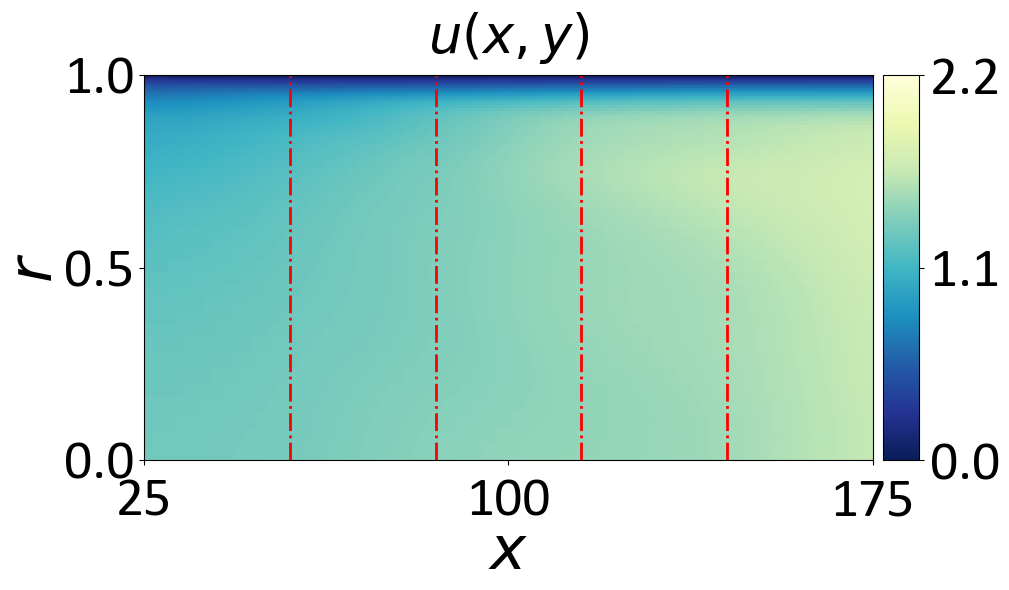

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


T: 1.292419195175171 1.0028254985809326


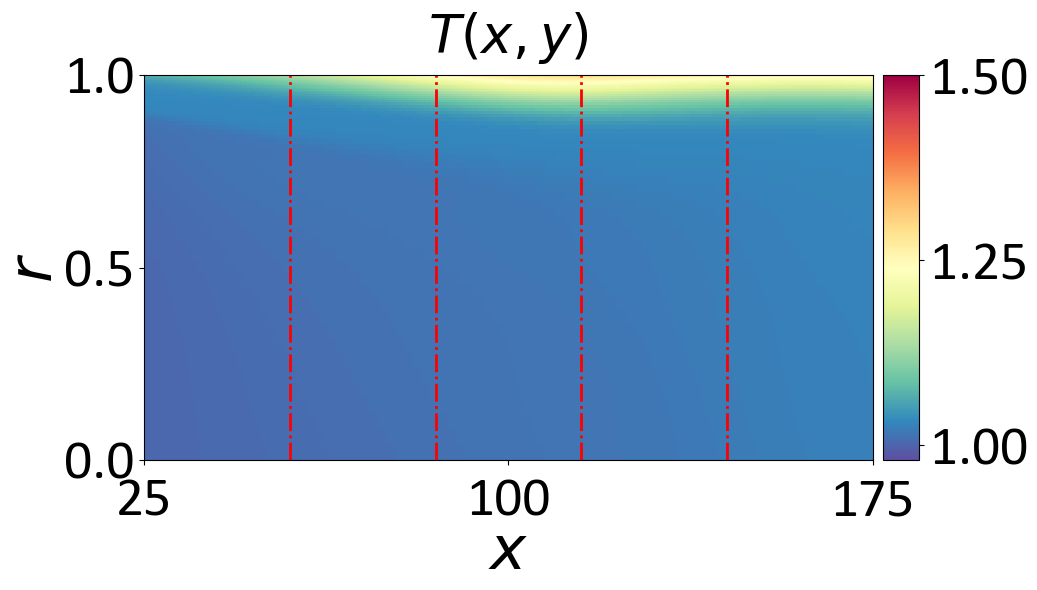

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


D: 0.9854372143745422 0.15988579392433167


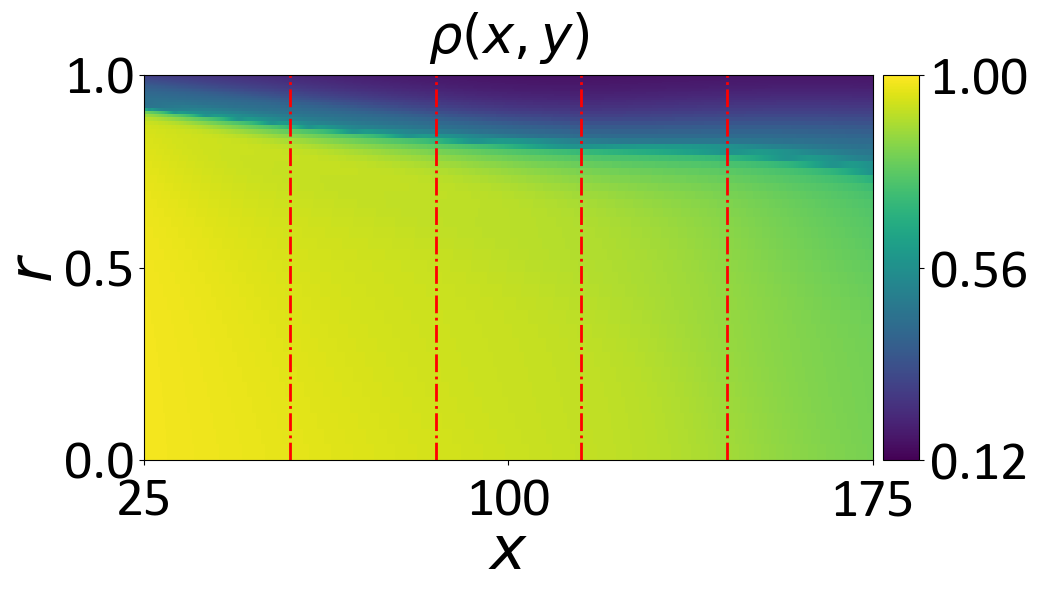

In [42]:
print('u:', uu_pred.max(), uu_pred.min())
plot_heatmap_pcolor(X_dns[idx_draw_X, :, 0], R_dns[idx_draw_X, :, 0], uu_pred, vmax=2.2, vmin=0, figsize=(10, 5), TITLE=True, feats=['$x$', '$r$', '$u (x,y)$'], VLIMIT=True, barlim=[0, 1.1, 2.2], cmap='YlGnBu_r', LEFT=True, BAR=True, BOTTOM=True, contour=0)
print('T:', TT_pred.max(), TT_pred.min())
plot_heatmap_pcolor(X_dns[idx_draw_X, :, 0], R_dns[idx_draw_X, :, 0], TT_pred, vmax=1.5, vmin=0.98, figsize=(10, 5), TITLE=True, feats=['$x$', '$r$', '$T (x,y)$'], VLIMIT=True, barlim=[1, 1.25, 1.5], cmap='Spectral_r', LEFT=True, BAR=True, BOTTOM=True, contour=0)
print('D:', DD_pred.max(), DD_pred.min())
plot_heatmap_pcolor(X_dns[idx_draw_X, :, 0], R_dns[idx_draw_X, :, 0], DD_pred, vmax=1, vmin=0.12, figsize=(10, 5), TITLE=True, feats=['$x$', '$r$', '$\\rho (x,y)$'], VLIMIT=True, barlim=[0.12, 0.56, 1], LEFT=True, BAR=True, BOTTOM=True, contour=0)

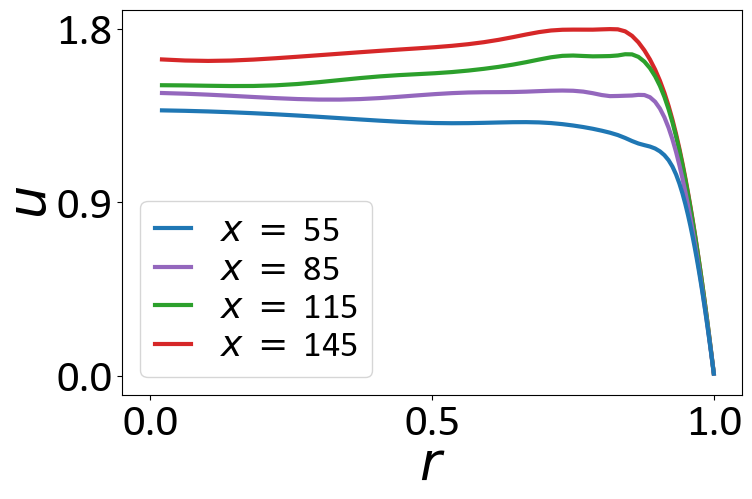

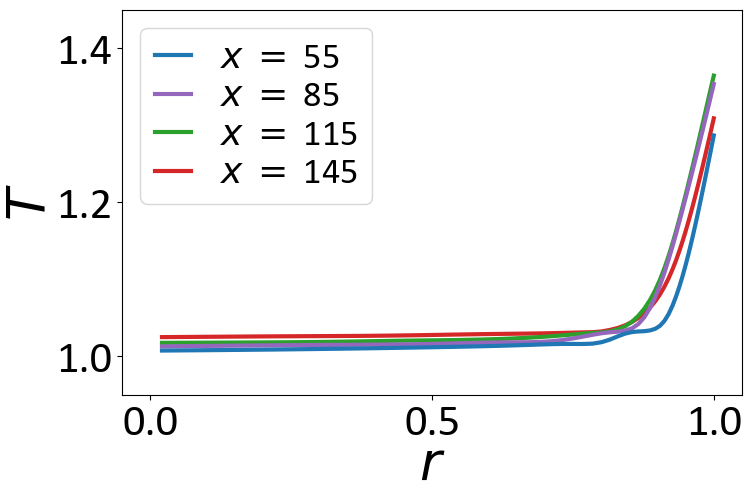

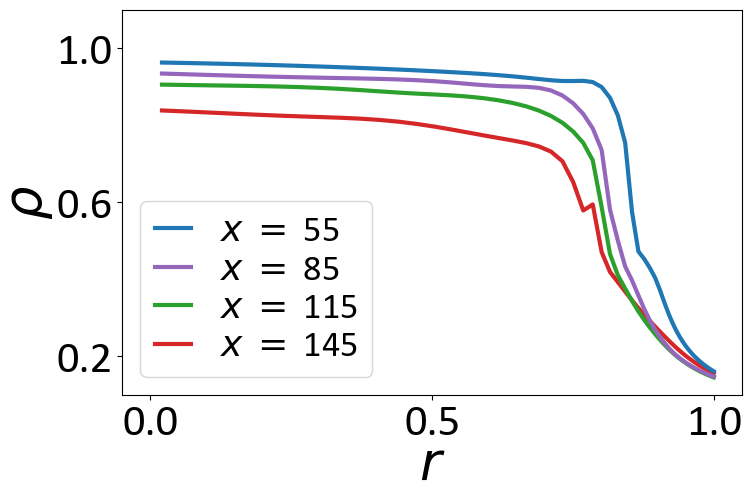

In [36]:
X_sec_draw = np.ones((64,3))
X_sec_draw[:, 1] = r_star_dns.flatten()
X_sec_draw[:, 2] = q_exp[3]
set_default_params()
plt.figure(figsize=(8,5))
x_draw_list = [55, 85, 115, 145]
color = ['tab:blue', 'tab:purple', 'tab:green',  'tab:red']
for i in range(4):
    X_sec_draw[:, 0] = x_draw_list[i]
    u_pred_sec, v_pred_sec, p_pred_sec, T_pred_sec, Mt_pred_sec, kt_pred_sec = thcs.predict(X_sec_draw)
    D_pred_sec, M_pred_sec, k_pred_sec, h_pred_sec = thcs.predict_prop(T_pred_sec)
    plt.plot(r_star_dns, u_pred_sec, ls='-', color=color[i], lw=3, zorder=(4-i), label='$x$ $=$ '+str(x_draw_list[i]))
    plt.xlabel('$r$', fontsize=38, labelpad=1)
    plt.ylabel('$u$', fontsize=38, labelpad=1)
    plt.legend(frameon=True, fontsize=26, handlelength=1, labelspacing=0.2)
plt.xlim((-0.05, 1.05))
plt.xticks([0, 0.5, 1.0], fontsize=32)
plt.ylim((-0.1, 1.9))
plt.yticks([0, 0.9, 1.8], fontsize=32)
plt.show()

set_default_params()
plt.figure(figsize=(8,5))
x_draw_list = [55, 85, 115, 145]
color = ['tab:blue', 'tab:purple', 'tab:green', 'tab:red']
for i in range(4):
    X_sec_draw[:, 0] = x_draw_list[i]
    u_pred_sec, v_pred_sec, p_pred_sec, T_pred_sec, Mt_pred_sec, kt_pred_sec = thcs.predict(X_sec_draw)
    D_pred_sec, M_pred_sec, k_pred_sec, h_pred_sec = thcs.predict_prop(T_pred_sec)
    plt.plot(r_star_dns, T_pred_sec, ls='-', color=color[i], lw=3, zorder=(4-i), label='$x$ $=$ '+str(x_draw_list[i]))
    plt.xlabel('$r$', fontsize=38, labelpad=1)
    plt.ylabel('$T$', fontsize=38, labelpad=1)
    plt.legend(frameon=True, fontsize=26, handlelength=1, labelspacing=0.2)
plt.xlim((-0.05, 1.05))
plt.xticks([0, 0.5, 1.0], fontsize=32)
plt.ylim((0.95, 1.45))
plt.yticks([1, 1.2, 1.4], fontsize=32)
plt.show()

set_default_params()
plt.figure(figsize=(8,5))
x_draw_list = [55, 85, 115, 145]
color = ['tab:blue', 'tab:purple', 'tab:green',  'tab:red']
for i in range(4):
    X_sec_draw[:, 0] = x_draw_list[i]
    u_pred_sec, v_pred_sec, p_pred_sec, T_pred_sec, Mt_pred_sec, kt_pred_sec = thcs.predict(X_sec_draw)
    D_pred_sec, M_pred_sec, k_pred_sec, h_pred_sec = thcs.predict_prop(T_pred_sec)
    plt.plot(r_star_dns, D_pred_sec, ls='-', color=color[i], lw=3, zorder=(4-i), label='$x$ $=$ '+str(x_draw_list[i]))
    plt.xlabel('$r$', fontsize=38, labelpad=1)
    plt.ylabel('$\\rho$', fontsize=38, labelpad=1)
    plt.legend(frameon=True, fontsize=26, handlelength=1, labelspacing=0.2)
plt.xlim((-0.05, 1.05))
plt.xticks([0, 0.5, 1.0], fontsize=32)
plt.ylim((0.1, 1.1))
plt.yticks([0.2, 0.6, 1.0], fontsize=32)
plt.show()